In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from typing import Sequence
import os

from datetime import date, timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import random

import jaxopt
import optax
from jaxopt import OptaxSolver
from jaxopt import objective
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative

import flax.linen as nn

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

import cel_utils.disk_utils as du

from tqdm.auto import tqdm

In [3]:
auth_token_fp = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
offline_data = 'offline_lock_target_optim'
os.makedirs(offline_data, exist_ok=True)
output_dir = '/Users/kiran/Documents/lock_target_optim'
os.makedirs(output_dir, exist_ok=True)

In [4]:
start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 1080
end_date = current_date + timedelta(days=forecast_length)
jax_offline_data = data.get_simulation_data(auth_token_fp, start_date, current_date, end_date)

In [5]:
rr_val = 0.8
fpr_val = 0.8
sector_duration = 360
lock_target = 0.3

def get_simulation_results(rbp_trajectory):
    rr = jnp.ones(forecast_length) * rr_val
    fpr = jnp.ones(forecast_length) * fpr_val
    
    simulation_results = sim.run_sim(
        rbp_trajectory,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        jax_offline_data
    )
    return simulation_results

def get_l_cs_trajectory(rbp_trajectory):
    simulation_results = get_simulation_results(rbp_trajectory)
    # compute actual l/cs
    l_over_cs_trajectory = simulation_results['network_locked'] / simulation_results['circ_supply']
    return l_over_cs_trajectory
    
def lt_objective(rbp_trajectory):
    l_over_cs_trajectory = get_l_cs_trajectory(rbp_trajectory)
    err = jnp.sum((l_over_cs_trajectory - lock_target)**2)
    return err

In [6]:
# For debugging
# init_rbp_trajectory = 40 * jnp.ones(forecast_length)
# lt_objective(init_rbp_trajectory)

In [7]:
pg = ProjectedGradient(fun=lt_objective, projection=projection_non_negative)
init_rbp_trajectory = 10 * jnp.ones(forecast_length)

In [8]:
state = pg.init_state(init_rbp_trajectory)
params = init_rbp_trajectory
maxiter=100
for _ in range(maxiter):
    params, state = pg.update(params, state)
#     print(state.error)

In [9]:
sim_results = get_simulation_results(params)

<IPython.core.display.Javascript object>


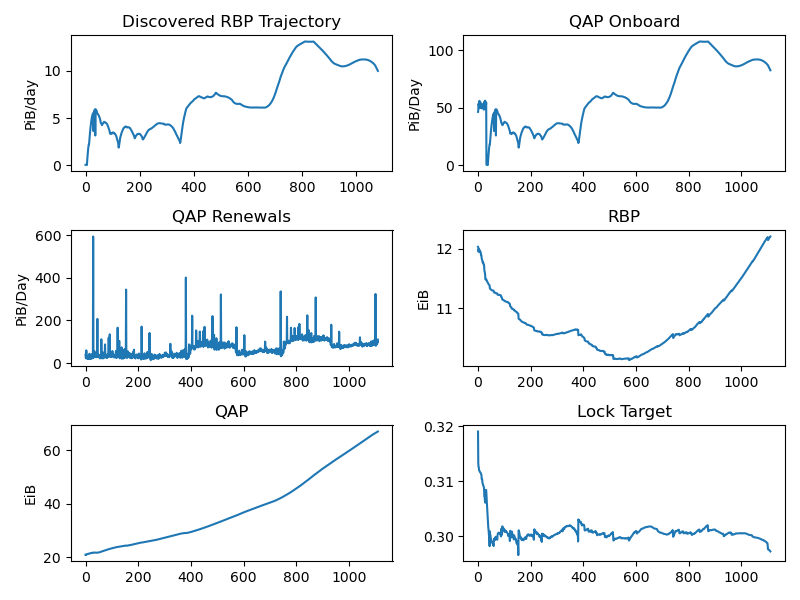

In [10]:
plt.figure(figsize=(8,6))

plt.subplot(3,2,1)
plt.plot(params)
plt.title('Discovered RBP Trajectory')
plt.ylabel('PiB/day')

plt.subplot(3,2,2)
plt.plot(sim_results['day_onboarded_power_QAP_PIB'])
plt.title('QAP Onboard')
plt.ylabel('PiB/Day')

plt.subplot(3,2,3)
plt.plot(sim_results['day_renewed_power_QAP_PIB'])
plt.title('QAP Renewals')
plt.ylabel('PiB/Day')

plt.subplot(3,2,4)
plt.plot(sim_results['network_RBP_EIB'])
plt.title('RBP')
plt.ylabel('EiB')

plt.subplot(3,2,5)
plt.plot(sim_results['network_QAP_EIB'])
plt.title('QAP')
plt.ylabel('EiB')

plt.subplot(3,2,6)
plt.plot(sim_results['network_locked']/sim_results['circ_supply'])
plt.title('Lock Target')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'rbp_discovery.png'))